# Time Series Analysis 
- What is a time series?
- How do we analyze it?
- Components: trend, seasonality, cycle, irregular
- Stationary vs non-stationary data
- Basic transformation to make a series more suitable for modeling


In [2]:
# Cell 1: Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


## 1. What is Time Series Analysis?

> **Time Series Analysis** is the study of how a variable changes over time,  
> treating **time** (day, month, year, etc.) as the independent variable and some **measure** (sales, stock price, temperature, etc.) as the response/target.

Examples:
- Daily stock prices (TSLA, AAPL, etc.)
- Monthly sales
- Hourly temperature
- Website traffic per day

In this notebook, we will **simulate** a simple monthly sales time series to keep things reproducible and easy to run.


In [3]:
# Cell 2: Create a simple synthetic time series

np.random.seed(42)

# Create a monthly date range for 5 years
dates = pd.date_range(start="2018-01-01", end="2022-12-01", freq="MS")  # MS = month start
n = len(dates)

# Components:
# 1. Trend: gradually increasing over time
trend = 10 + 0.5 * np.arange(n)

# 2. Seasonality: yearly pattern repeating every 12 months (e.g., higher at year-end)
seasonal_pattern = [2, 1, 0, -1, -2, -1, 0, 1, 2, 3, 4, 3]
seasonality = np.tile(seasonal_pattern, n // 12)

# 3. Cyclic component: slow, irregular waves (we keep it small for demo)
cycle = 1.5 * np.sin(np.linspace(0, 3 * np.pi, n))

# 4. Irregular component (noise)
noise = np.random.normal(loc=0, scale=1.0, size=n)

# Combine everything
sales = trend + seasonality + cycle + noise

ts = pd.DataFrame({"Date": dates, "Sales": sales}).set_index("Date")
ts.head()


,Sales
Date,
2018-01-01,12.496714
2018-02-01,11.600331
2018-03-01,12.118804
2018-04-01,12.714669
2018-05-01,10.660398


In [13]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2018-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


### 2. Visualizing Time vs Key Feature

First step in time series analysis is usually:
1. Collect and clean the data  
2. **Plot it against time** to see patterns (trend, seasonality, noise).

Let's plot our simulated monthly sales.


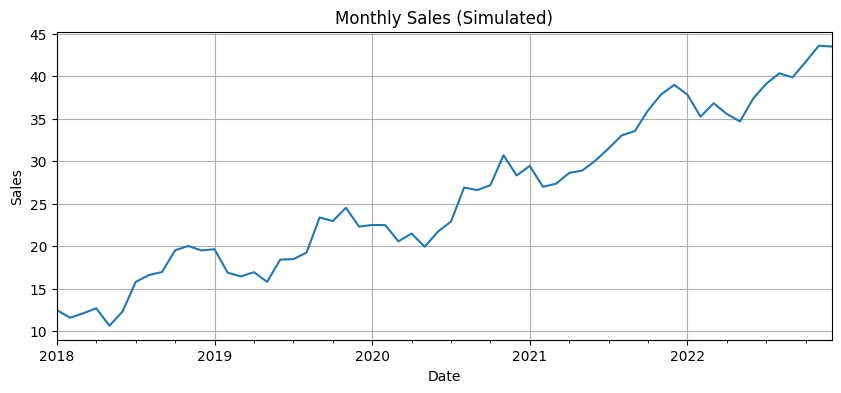

In [4]:
# Cell 3: Plot the full time series

ts["Sales"].plot()
plt.title("Monthly Sales (Simulated)")
plt.ylabel("Sales")
plt.show()


Interpretation of Monthly Sales Trend

The plot shows a clear upward trend in monthly sales from 2018 to 2022.
Although the values fluctuate month-to-month, the overall direction is consistently rising, indicating:

Growing demand or business expansion over time

Seasonal or short-term variations, visible as small peaks and dips

No major long-term decline, suggesting stable performance

By late 2022, sales reach their highest levels, confirming strong positive momentum.




## 3. Components of Time Series

Time series can generally be broken into:

- **Trend** – Long-term increase/decrease (no fixed interval).
- **Seasonality** – Regular, fixed interval pattern (e.g., monthly, quarterly, yearly).
- **Cyclic** – Fluctuations over longer and *not strictly regular* periods (business cycles).
- **Irregular / Residual** – Random noise, unexpected spikes or drops.

We’ll use `seasonal_decompose` to visualize these components.


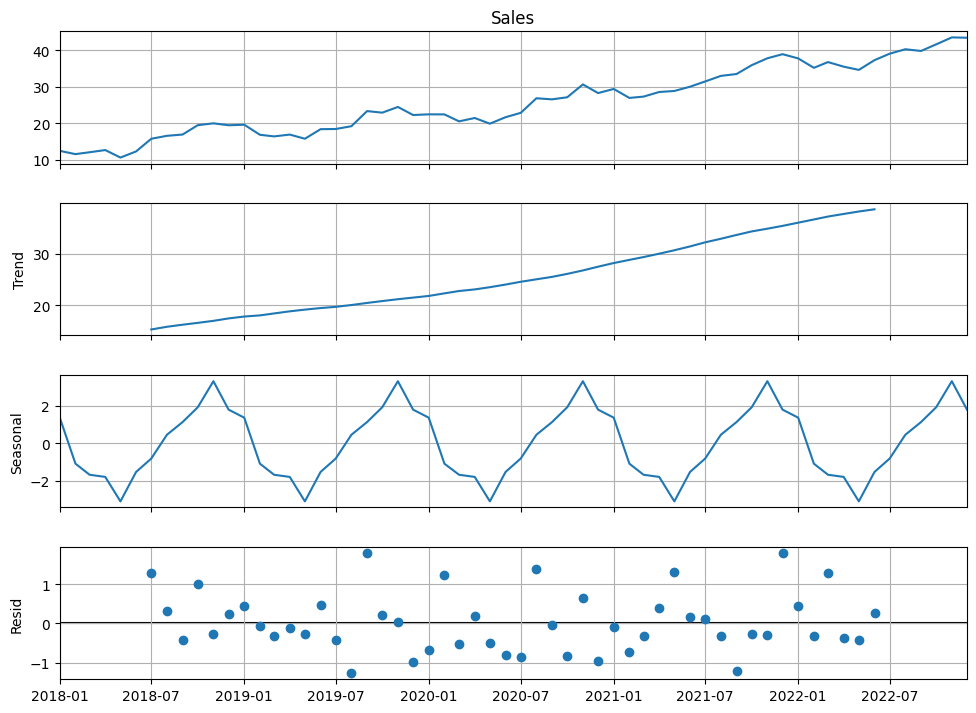

In [5]:
# Cell 4: Decompose the series into components

result = seasonal_decompose(ts["Sales"], model="additive", period=12)  # period=12 months

fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


Time Series Decomposition Interpretation

The decomposition breaks the Sales series into four components—Observed, Trend, Seasonal, and Residual—revealing how different patterns contribute to overall behavior:

1. Observed (Top Plot)

The original sales data shows a steady upward movement from 2018 to 2022, with visible short-term fluctuations.

2. Trend (Second Plot)

The trend component captures the long-term direction.
It shows a consistent and smooth increase, indicating that sales are growing steadily over the 5-year period.

3. Seasonal (Third Plot)

The seasonal component repeats every 12 months, showing regular annual patterns.
Sales are higher during certain months and lower during others, confirming a stable, repeating seasonal cycle.

4. Residual (Bottom Plot)

The residuals represent random noise left after removing trend and seasonality.
They fluctuate around zero with no clear pattern, meaning most of the structure in the data is well explained by the trend + seasonality components.


- **Observed**: Original time series  
- **Trend**: Smoothed long-term direction  
- **Seasonal**: Repeating yearly pattern  
- **Resid**: Irregular noise + any leftover structure  

> understanding these components helps us build better forecasting models and interpret what’s happening in the data.


## 4. Stationary vs Non-Stationary Time Series

### 4.1 Definitions

- **Stationary series**:
  - Mean is constant over time  
  - Variance is constant over time  
  - Covariance (relationship between values at different times) is stable
  - No trend or seasonality

- **Non-stationary series**:
  - Opposite of above (e.g., has trend or seasonality)
  - Most real-world data is non-stationary and must be **transformed**.

Our simulated series has **trend + seasonality**, so it is non-stationary.

Let’s visually check using a rolling mean and rolling standard deviation.


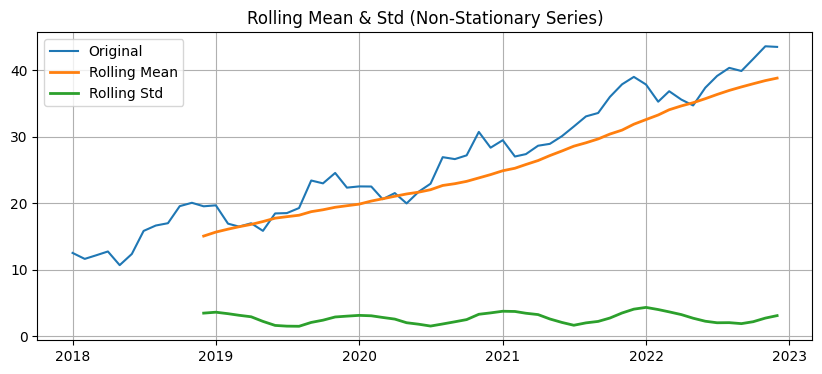

In [6]:
# Cell 5: Rolling statistics to check stationarity visually

window = 12  # 1 year

rolling_mean = ts["Sales"].rolling(window=window).mean()
rolling_std = ts["Sales"].rolling(window=window).std()

plt.plot(ts["Sales"], label="Original")
plt.plot(rolling_mean, label="Rolling Mean", linewidth=2)
plt.plot(rolling_std, label="Rolling Std", linewidth=2)
plt.legend()
plt.title("Rolling Mean & Std (Non-Stationary Series)")
plt.show()


Interpretation of Rolling Mean & Standard Deviation

The plot shows the original time series alongside its rolling mean and rolling standard deviation, helping us assess stationarity:

Rolling Mean (orange) steadily increases over time, indicating a clear upward trend in the data.

Rolling Standard Deviation (green) changes over time rather than staying flat, meaning the amount of fluctuation is not constant.

Together, this confirms that the series is non-stationary, since both the average level and variability shift over the years.

In summary, the presence of a rising trend and changing variance means the data must be transformed (e.g., differenced) before applying models that require stationarity.

In [ ]:
# Cell 6: ADF test on original series

adf_result = adfuller(ts["Sales"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.3f}")



ADF Statistic: 2.234990343083436
p-value: 0.9989100824851416
Critical Value (1%): -3.571
Critical Value (5%): -2.923
Critical Value (10%): -2.599


Interpretation:
p-value < 0.05 → reject null → series is stationary
p-value ≥ 0.05 → fail to reject null → series is non-stationary

ADF Test Interpretation
ADF Statistic: 2.2349
p-value: 0.9989
Critical Values:
1%: -3.571
5%: -2.923
10%: -2.599
Conclusion:
The p-value is much greater than 0.05, and the ADF Statistic (2.23) is not more negative than any of the critical values.
 We fail to reject the null hypothesis.
 The series is non-stationary.

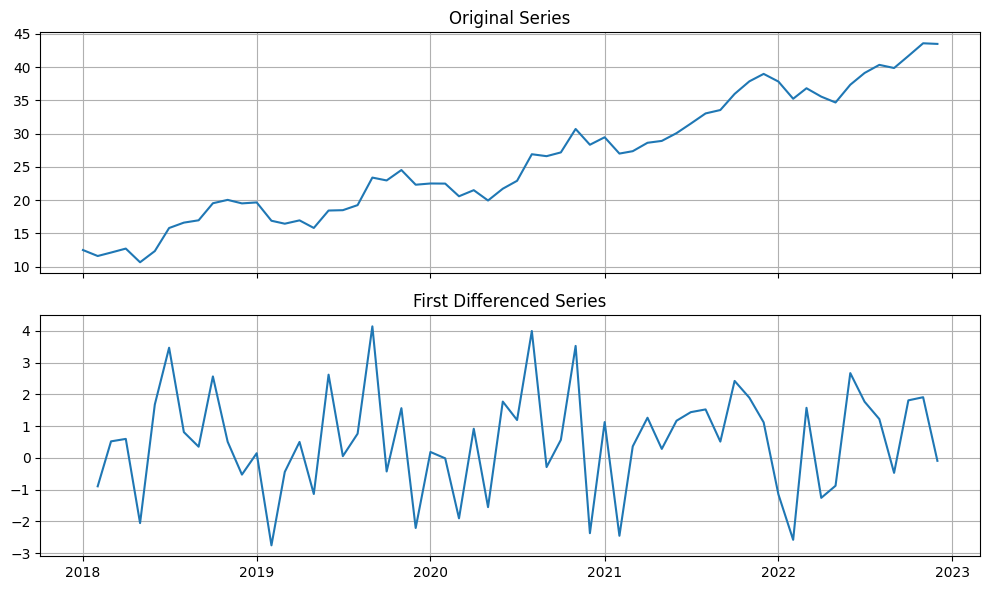

In [8]:
# Cell 7: First-order differencing

ts_diff = ts["Sales"].diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(ts["Sales"])
axes[0].set_title("Original Series")

axes[1].plot(ts_diff)
axes[1].set_title("First Differenced Series")
plt.tight_layout()
plt.show()


Interpretation of Original vs. First Differenced Series
Original Series (Top Plot)

The original sales data shows a strong upward trend from 2018 to 2022, with clear long-term growth and changing levels over time. This indicates the series is non-stationary.

First Differenced Series (Bottom Plot)

After differencing, the trend is removed and the values now fluctuate around zero with a more stable variance. This makes the series closer to stationary, which is required for many forecasting models like ARIMA.

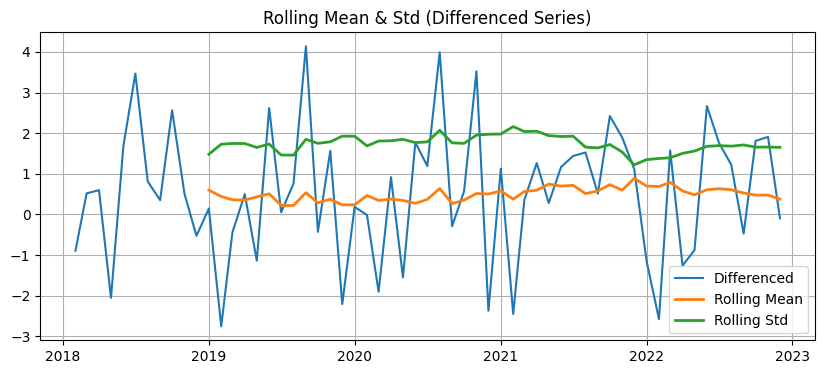

ADF Statistic (diff): -4.93904043437647
p-value (diff): 2.9259257420273244e-05
Critical Value (1%): -3.571
Critical Value (5%): -2.923
Critical Value (10%): -2.599


In [9]:
# Cell 8: Rolling stats and ADF on differenced series

rolling_mean_diff = ts_diff.rolling(window=12).mean()
rolling_std_diff = ts_diff.rolling(window=12).std()

plt.plot(ts_diff, label="Differenced")
plt.plot(rolling_mean_diff, label="Rolling Mean", linewidth=2)
plt.plot(rolling_std_diff, label="Rolling Std", linewidth=2)
plt.legend()
plt.title("Rolling Mean & Std (Differenced Series)")
plt.show()

# ADF test
adf_result_diff = adfuller(ts_diff)
print("ADF Statistic (diff):", adf_result_diff[0])
print("p-value (diff):", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value:.3f}")


Interpretation of Differenced Series (Rolling Mean & Std)

After differencing, the rolling mean and rolling standard deviation appear much more stable compared to the original series.
This indicates that the trend has been removed and the variance is now more consistent.
 The differenced series behaves much closer to stationary.

 ADF Test Interpretation (Differenced Series)
ADF Statistic = -4.94
p-value = 0.000029
Critical values (1% = -3.571, 5% = -2.923, 10% = -2.599)
Since the ADF statistic is lower (more negative) than all critical values and the p-value is far below 0.05, we reject the null hypothesis.

Conclusion: The differenced series is stationary.

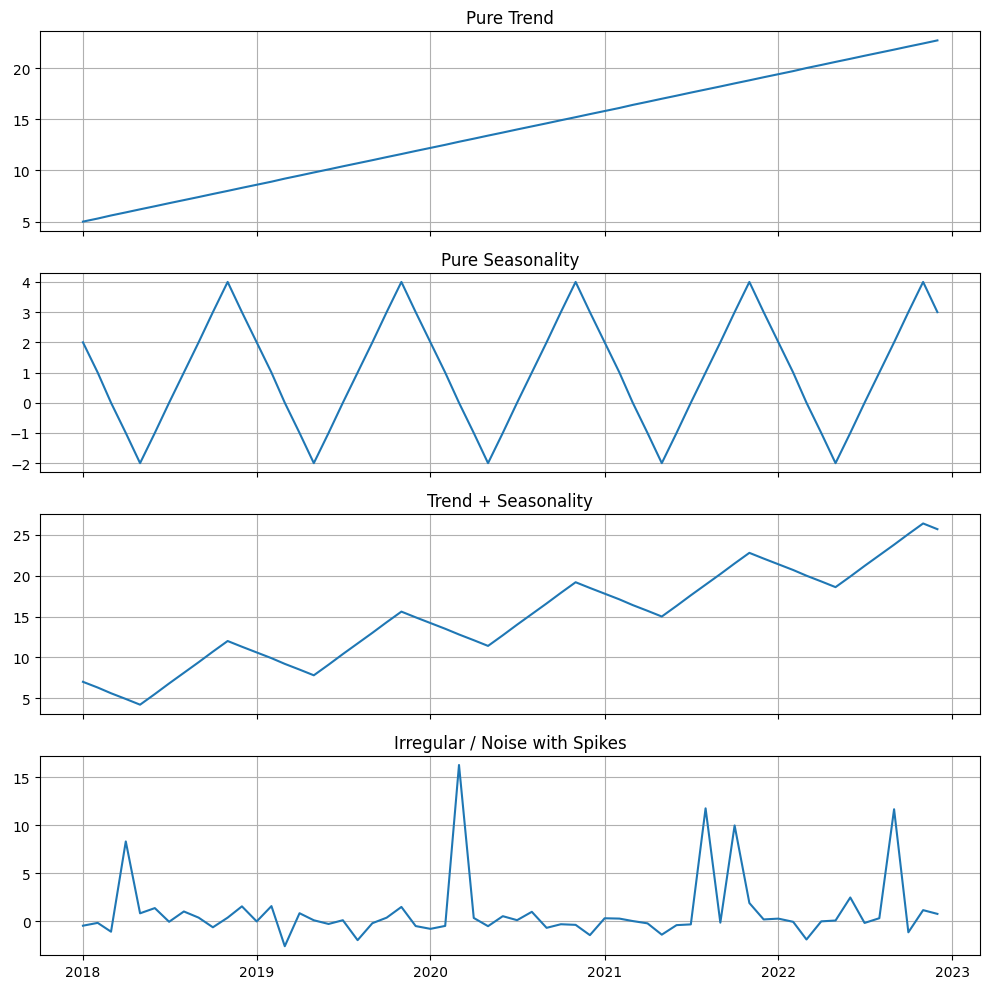

In [10]:
# Cell 9: Simulate and plot components separately

time = np.arange(n)

# Pure trend
pure_trend = 5 + 0.3 * time

# Pure seasonality (same pattern repeated)
pure_seasonality = np.tile(seasonal_pattern, n // 12)

# Irregular (noise + spikes)
irregular = np.random.normal(0, 1, n)
# Add a few random spikes
spike_indices = np.random.choice(n, size=5, replace=False)
irregular[spike_indices] += np.random.normal(10, 3, 5)

fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axes[0].plot(dates, pure_trend)
axes[0].set_title("Pure Trend")

axes[1].plot(dates, pure_seasonality)
axes[1].set_title("Pure Seasonality")

axes[2].plot(dates, pure_trend + pure_seasonality)
axes[2].set_title("Trend + Seasonality")

axes[3].plot(dates, irregular)
axes[3].set_title("Irregular / Noise with Spikes")

plt.tight_layout()
plt.show()


In [11]:
# Cell 10: Quick demo of missing values impact

ts_with_nan = ts.copy()
# artificially introduce some NaNs
nan_indices = np.random.choice(len(ts_with_nan), size=5, replace=False)
ts_with_nan.iloc[nan_indices, 0] = np.nan

print("Number of missing values:", ts_with_nan["Sales"].isna().sum())

# Try decomposition with missing values (will usually error or warn)
try:
    seasonal_decompose(ts_with_nan["Sales"], model="additive", period=12)
except Exception as e:
    print("Decomposition failed due to missing values:")
    print(e)


Number of missing values: 5
Decomposition failed due to missing values:
This function does not handle missing values


### Fixing missing values

Common strategies:
- Forward fill (`ffill`)  
- Interpolation (`interpolate`)  
- Dropping missing rows (if few)


Missing values after interpolation: 0


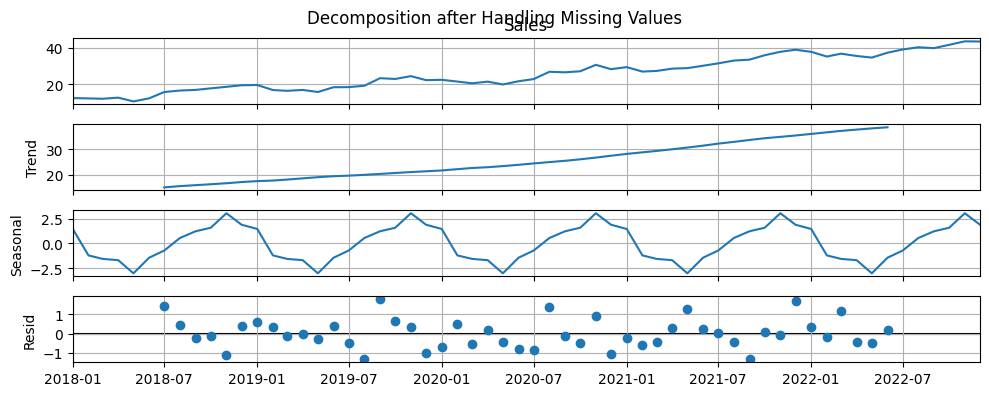

In [12]:
# Cell 11: Handle missing values and decompose again

ts_filled = ts_with_nan.copy()
ts_filled["Sales"] = ts_filled["Sales"].interpolate()

print("Missing values after interpolation:", ts_filled["Sales"].isna().sum())

result_filled = seasonal_decompose(ts_filled["Sales"], model="additive", period=12)
result_filled.plot()
plt.suptitle("Decomposition after Handling Missing Values")
plt.show()
